## Face Colorization

In [4]:
import numpy as np
import os 
import cv2
import sys 
from tqdm import tqdm
#from pycocotools.coco import COCO
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import UpSampling2D,Conv2D,LSTM,Bidirectional,Dropout,BatchNormalization,Flatten,MaxPool2D
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.image import img_to_array,load_img,ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow.keras.layers import add
from PIL import Image
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.resnet import ResNet50
from sklearn.utils import shuffle
import seaborn as sn
import pickle
import string
import random
import tensorflow as tf 
from skimage.io import imsave
import matplotlib.pyplot as plt
from skimage.color import rgb2lab,lab2rgb
from skimage.transform import resize
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import keras

In [41]:
class MODEL_HELPER:
    def __init__(self,data,total_img_select,batch_size,path,train=True):
        self.X = data
        self.batch_size = batch_size
        self.PATH = path
        self.total_img_select = total_img_select

        if train==False:
            return self.__load_model()
        
    @classmethod
    def load_model(self):
        """
                Load the trained model
        """
        model_ = tf.keras.models.load_model(

                r'D:\Image Color Models\colorize_autoencoder8000face.model',
                custom_objects=None,
                compile=True

        )
        return model_ 

    def train_model(self):
        """
                Train the model and save it in path specified
        """
        model = self.__MODEL()
        save_model = self.__SAVE_MODEL(model)
        return model
    
    def __SAVE_MODEL(self,model_):
        ''' 
                Save model in specified path
        '''
        model_.save(r'D:\Image Color Models\colorize_autoencoder8000face.model')

    def __select_sample(self):
        """
                'Select_sample' will select a particular amount of sample from a huge training Data 
                For example, from 50K images we selected 8000 images for training. 
        """
        sample = random.sample(self.X,self.total_img_select)
        #sample = shuffle(sample)
        return sample 
    
    def __image_processing(self,image_):
        """
                Pre_Processing of images (
                    Rescale 
                    Resize
                    Normalize    
                )
        """
        image_ = img_to_array(load_img(os.path.join(path,image_),target_size=(256,256)))
        image_ = image_/255
        image_ = rgb2lab(image_)
        return image_
    
    def __batch_generator(self):
        """
                This function 'batch_generator' will generate batches of images and will send it to
                the model in every iteration it's required because of huge training data fedding 
                all the images at the same time will be very inefficent as it will consume large amount of RAM.     
        """
        total_images = self.__select_sample()
        while True:
            inputs = []
            targets = []
            batchcount = 0
            for image in total_images:
                image = self.__image_processing(image)
                inputs.append(image[:,:,0])
                targets.append(image[:,:,1:]/128)
                batchcount += 1
                if batchcount > batch_size:

                    X = np.array(inputs)
                    Y = np.array(targets)
                    X = X.reshape(X.shape + (1,))

                    yield X,Y
                    
                    inputs = []
                    targets = []
                    batchcount = 0
    
    def __MODEL(self):
        """
                We will use convolutional autoencoders to train the model 
        """ 
        
        model = Sequential()
        model.add(Conv2D(64, (3, 3), activation='relu', padding='same', strides=2, input_shape=(256, 256, 1)))
        model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
        model.add(Conv2D(128, (3,3), activation='relu', padding='same', strides=2))
        model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
        model.add(Conv2D(256, (3,3), activation='relu', padding='same', strides=2))
        model.add(Conv2D(512, (3,3), activation='relu', padding='same'))
        model.add(Conv2D(512, (3,3), activation='relu', padding='same'))
        model.add(Conv2D(256, (3,3), activation='relu', padding='same'))

        model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
        model.add(UpSampling2D((2, 2)))
        model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
        model.add(UpSampling2D((2, 2)))
        model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
        model.add(Conv2D(16, (3,3), activation='relu', padding='same'))
        model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
        model.add(UpSampling2D((2, 2)))

        model.compile(optimizer='adam',loss='mse',metrics=['accuracy'])
        #model.summary()

        model.fit(self.__batch_generator(),steps_per_epoch=(self.total_img_select)/self.batch_size,epochs=100)
        return model

In [26]:
path = 'D:/Face Images' #Training face images path
images = os.listdir(path) 
batch_size = 16 #Select a batch size 
total_image_select = 8000 # Select total image to sample from 50K images 

train_iter_ = MODEL_HELPER(images,total_image_select,batch_size,path)

In [ ]:
model = train_iter_.train_model()

In [38]:
class Prediction():
    def predict(self,path):
        for test_im in path:
            pred= []
            pred_img = img_to_array(load_img('C:/Users/BABI/Image Colorization/test/{}'.format(test_im)))
            pred_img = resize(pred_img,(256,256))
            pred.append(pred_img)
            pred = np.array(pred,dtype=float)
            pred = rgb2lab(1.0/255 * pred)[:,:,:,0]
            pred = pred.reshape(pred.shape+(1,))
            output = model.predict_generator(pred)
            output = output * 128
            result = np.zeros((256,256,3))
            result[:,:,0] = pred[0][:,:,0]
            result[:,:,1:] = output[0]
            imsave('{}new.png'.format(tes_im+str('new2')),lab2rgb(result))

In [40]:
pred = Prediction()
pred.predict(os.listdir('C:/Users/BABI/Image Colorization/test'))

## Some predcition results 

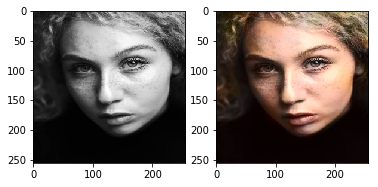

In [55]:
import matplotlib.image as mpimg
original = mpimg.imread('C:/Users/BABI/Image Colorization/pred/pexels-photo-3460478.jpeg')
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(resize(original,(256,256)))
prediction = mpimg.imread('C:/Users/BABI/Image Colorization/predict.png')
ax2.imshow(prediction)